In [6]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from datetime import datetime, timedelta

## Завдання 1: Аналіз чутливості параметрів стохастичних моделей

### Природничі процеси (Популяційний ріст):
- Проведіть аналіз чутливості, змінюючи параметри $k$, $K$ та $\sigma$, і побудуйте графіки для обох підходів. Проаналізуйте, як зміна цих параметрів впливає на траєкторію популяції.

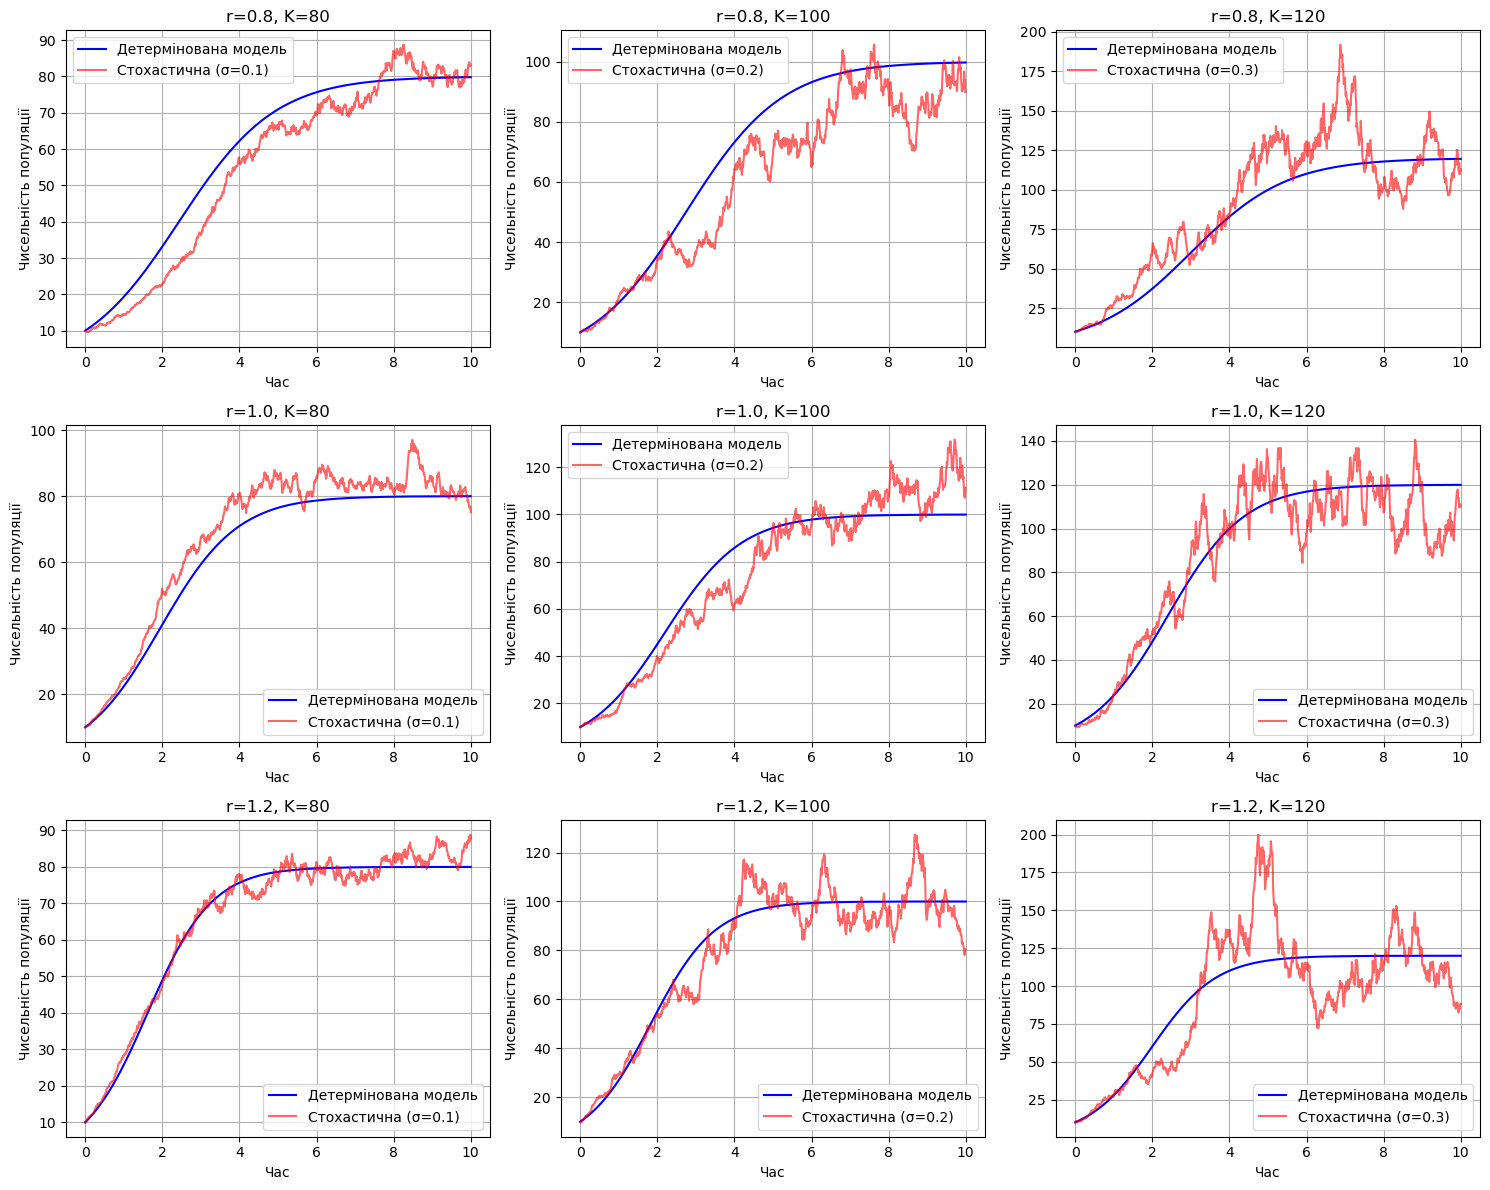

In [2]:
r_values = [0.8, 1.0, 1.2]      # Значення швидкості зростання
K_values = [80, 100, 120]       # Значення місткості середовища
sigma_values = [0.1, 0.2, 0.3]  # Інтенсивность шуму
y0 = 10.0                       # Початкове значення популяції
t_span = (0, 10)                # Інтервал часу
t_eval = np.linspace(t_span[0], t_span[1], 100)  # Часовий вектор

# Функція детермінованої моделі
def logistic_model(t, y, r, K):
    return r * y * (1 - y / K)

# Метод Euler–Maruyama для стохастичної моделі
def stochastic_logistic(y0, r, K, sigma, n_steps=1000, T=10):
    dt = T / n_steps
    t_stoch = np.linspace(0, T, n_steps)
    y_stoch = np.zeros(n_steps)
    y_stoch[0] = y0
    
    for i in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt))  # Приріст Вінерівського процесу
        y_stoch[i] = y_stoch[i-1] + r * y_stoch[i-1] * (1 - y_stoch[i-1] / K) * dt + sigma * y_stoch[i-1] * dW
        y_stoch[i] = max(y_stoch[i], 0)  # Забезпечення додатності популяції
    
    return t_stoch, y_stoch

# Побудова графіків для різних значень параметрів
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
for i, r in enumerate(r_values):
    for j, K in enumerate(K_values):
        # Детерміноване рішення
        solution = solve_ivp(logistic_model, t_span, [y0], args=(r, K), t_eval=t_eval)
        y_det = solution.y[0]
        
        # Стохастичне рішення
        t_stoch, y_stoch = stochastic_logistic(y0, r, K, sigma_values[j])

        axs[i, j].plot(t_eval, y_det, 'b-', label="Детермінована модель")
        axs[i, j].plot(t_stoch, y_stoch, 'r-', alpha=0.6, label=f"Стохастична (σ={sigma_values[j]})")
        axs[i, j].set_title(f"r={r}, K={K}")
        axs[i, j].set_xlabel("Час")
        axs[i, j].set_ylabel("Чисельність популяції")
        axs[i, j].legend()
        axs[i, j].grid()

plt.tight_layout()
plt.show()

Розберемо результати по параметрам:
1. Зміна $r$ (швидкість росту):
    - Для детермінованої моделі збільшення $r$ призводить до більш швидкого досягнення рівноваги.
    - Для стохастичних моделей при зростанні $r$ бачимо збільшення кількості варіацій в популяції.

2. Зміна $K$ (місткість середовища):
    - При збільшенні $K$ для детермінованої моделі максимальне можливе значення популяції зростає.
    - Стохастична модель сильніше відхиляється для більших $K$, оскільки розмах можливих значень більший. А отже спостерігаємо випадкові коливання.

3. Зміна $\sigma$ (інтенсивність шуму):
    - Зі збільшенням $\sigma$ розкид значень популяції значно збільшується.
    - Для великих $\sigma$ можливі навіть екстремальні зниження чисельності.

Висновки
- Детермінована модель добре описує середню динаміку, проте стохастична модель дає більш реалістичне уявлення про коливання популяції.
- В реальних екосистемах стохастичні фактори (зміни клімату, хижаки, нестача ресурсів) можуть значно впливати на розвиток популяції.
- Практичне застосування: управління рибним господарством, збереження видів, моделювання розповсюдження епідемій.

### Економічні процеси (Модель економічного замовлення, EOQ):
- Порівняйте оптимальні значення $Q$ для детермінованої та стохастичної моделей та проаналізуйте вплив невизначеності попиту.

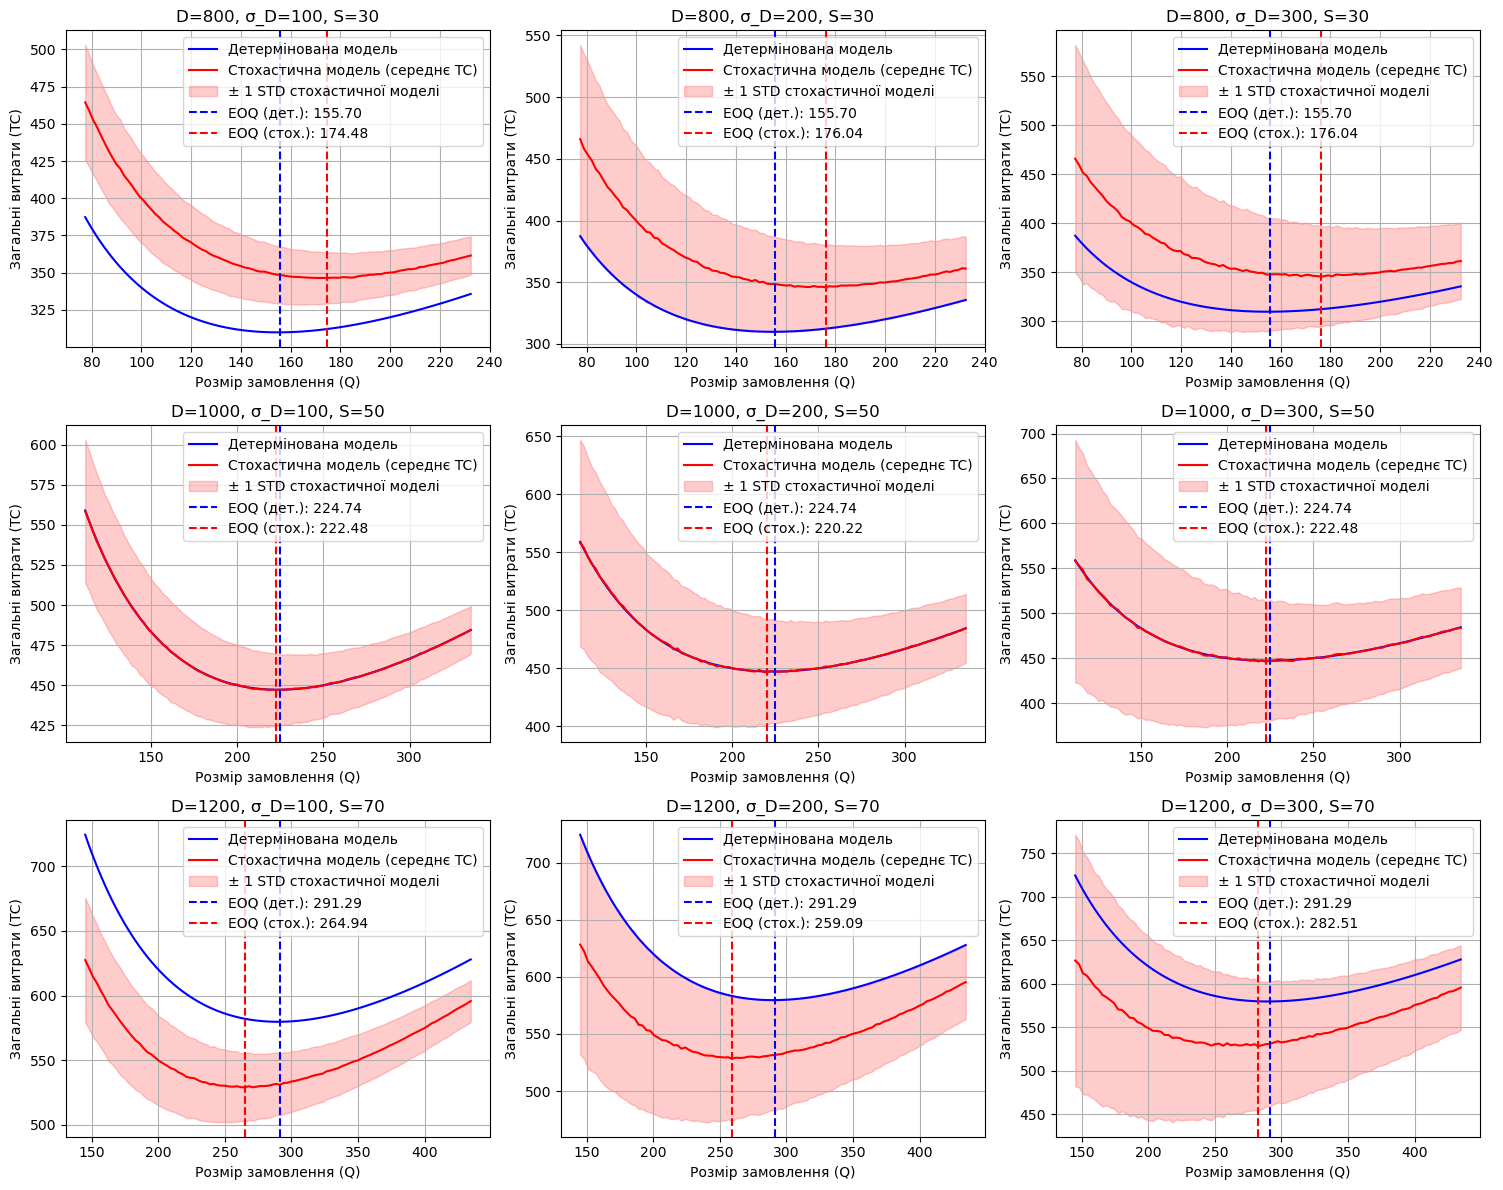

In [8]:
# Детерміновані параметри
D_values = [800, 1000, 1200]    # Рівні попиту
S_values = [30, 50, 70]         # Вартість оформлення замовлення
H = 2.0                         # Вартість зберігання одиниці товару за рік

# Оптимальна кількість замовлень (EOQ)
def compute_eoq(D, S, H):
    return math.sqrt((2 * D * S) / H)

# Загальні витрати (TC)
def total_cost(Q, D, S, H):
    return (D / Q) * S + (Q / 2) * H

# Стохастичні параметри
mu_D = 1000.0                       # Середній попит
sigma_D_values = [100, 200, 300]    # Різна невизначеність попиту
n_sim = 10000                       # Кількість симуляцій

fig, axs = plt.subplots(3, 3, figsize=(15, 12))
for i, D in enumerate(D_values):
    for j, sigma_D in enumerate(sigma_D_values):
        S = S_values[i]
        eoq = compute_eoq(D, S, H)

        # Генеруємо значення Q для побудови графіка
        Q_values = np.linspace(eoq * 0.5, eoq * 1.5, 100)
        TC_deterministic = np.array([total_cost(Q, D, S, H) for Q in Q_values])

        # Стохастична модифікація
        TC_stochastic_mean = []
        TC_stochastic_std = []

        for Q in Q_values:
            D_samples = np.maximum(np.random.normal(mu_D, sigma_D, n_sim), 0)
            TC_samples = (D_samples / Q) * S + (Q / 2) * H
            TC_stochastic_mean.append(np.mean(TC_samples))
            TC_stochastic_std.append(np.std(TC_samples))

        TC_stochastic_mean = np.array(TC_stochastic_mean)
        TC_stochastic_std = np.array(TC_stochastic_std)

        # Визначаємо оптимальні значення Q
        optimal_idx_det = int(np.argmin(TC_deterministic))
        optimal_idx_stoch = int(np.argmin(TC_stochastic_mean))
        Q_optimal_det = Q_values[optimal_idx_det]
        Q_optimal_stoch = Q_values[optimal_idx_stoch]

        axs[i, j].plot(Q_values, TC_deterministic, 'b-', label="Детермінована модель")
        axs[i, j].plot(Q_values, TC_stochastic_mean, 'r-', label="Стохастична модель (середнє TC)")
        axs[i, j].fill_between(
            Q_values,
            TC_stochastic_mean - TC_stochastic_std,
            TC_stochastic_mean + TC_stochastic_std,
            color='r', alpha=0.2, label="± 1 STD стохастичної моделі"
        )
        axs[i, j].axvline(Q_optimal_det, color='b', linestyle='--', label=f"EOQ (дет.): {Q_optimal_det:.2f}")
        axs[i, j].axvline(Q_optimal_stoch, color='r', linestyle='--', label=f"EOQ (стох.): {Q_optimal_stoch:.2f}")
        axs[i, j].set_title(f"D={D}, σ_D={sigma_D}, S={S}")
        axs[i, j].set_xlabel("Розмір замовлення (Q)")
        axs[i, j].set_ylabel("Загальні витрати (TC)")
        axs[i, j].legend()
        axs[i, j].grid()

plt.tight_layout()
plt.show()

Розберемо результати по параметрам:
1. Вплив попиту $D$:
    - Зі збільшенням $D$ оптимальне $Q^{*}$ також зростає.
    - Детерміноване рішення дає нижчий економічний розмір замовлення(EOQ), тоді як стохастичне може бути більшим для компенсації варіацій попиту.

2. Вплив стандартного відхилення $\sigma_D$​:
    - При збільшенні невизначеності попиту (зростання $\sigma_D$), середнє значення EOQ у стохастичній моделі зростає.
    - Варіативність витрат у стохастичній моделі значно вища, що видно з розмаху помилки.

3. Вплив вартості оформлення замовлення $S$:
    - Вища $S$ призводить до збільшення оптимального розміру замовлення.
    - Стохастична модель сильніше реагує на зміну $S$, намагаючись зменшити вплив невизначеності.

Висновки
- Детермінована модель підійде, якщо попит передбачуваний і стабільний.
- Стохастична модель більш гнучка і краще враховує ризики коливання попиту.
- Практичне застосування: управління запасами в логістиці, роздрібна торгівля.

### Соціальні процеси (Модель соціальної динаміки):
- Проаналізуйте, як початкове значення $x_0$ та критичний поріг $\theta$ впливають на кінцеву поведінку системи. Побудуйте графіки для детерміністичного та стохастичного рішень і сформулюйте висновки щодо стабільності рівноважних станів.

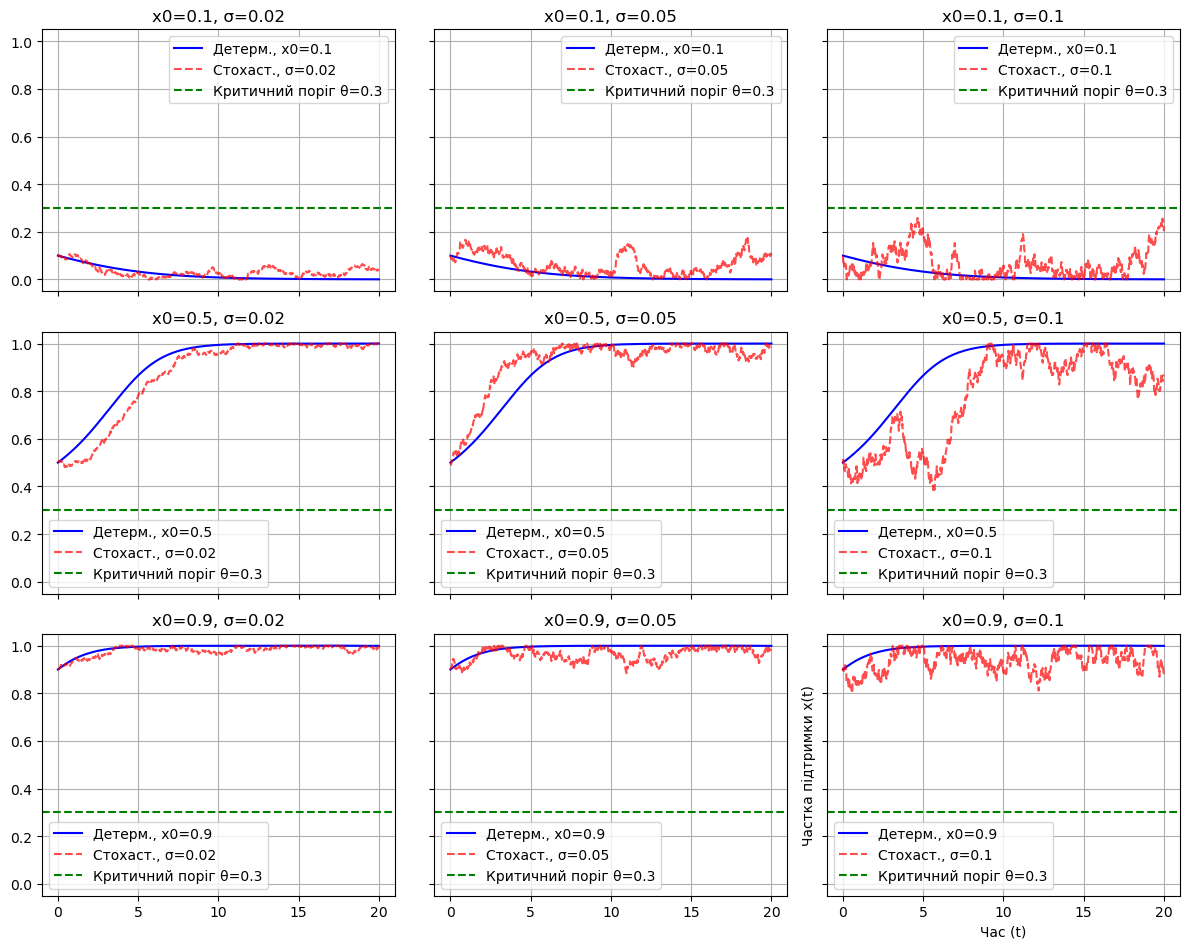

In [12]:
k = 1.0                             # Коефіцієнт швидкості
theta = 0.3                         # Критичний поріг
x0_values = [0.1, 0.5, 0.9]         # Початкові значення
sigma_values = [0.02, 0.05, 0.1]    # Рівні стохастичного шуму

t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 300)

# Функція для детерміністичної моделі
def social_dynamics(t, x):
    return k * x * (1 - x) * (x - theta)

# Функція для стохастичної моделі
def stochastic_dynamics(x0, sigma, n_steps=1000):
    dt = t_span[1] / n_steps
    t_stoch = np.linspace(t_span[0], t_span[1], n_steps)
    x_stoch = np.zeros(n_steps)
    x_stoch[0] = x0
    for i in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        f = k * x_stoch[i-1] * (1 - x_stoch[i-1]) * (x_stoch[i-1] - theta)
        x_stoch[i] = x_stoch[i-1] + f * dt + sigma * dW
        x_stoch[i] = np.clip(x_stoch[i], 0, 1)
    return t_stoch, x_stoch

fig, axes = plt.subplots(len(x0_values), len(sigma_values), figsize=(12, 10), sharex=True, sharey=True)
for i, x0 in enumerate(x0_values):
    solution = solve_ivp(social_dynamics, t_span, [x0], t_eval=t_eval)
    x_det = solution.y[0]
    
    for j, sigma in enumerate(sigma_values):
        t_stoch, x_stoch = stochastic_dynamics(x0, sigma)
        
        ax = axes[i, j]
        ax.plot(t_eval, x_det, label=f"Детерм., x0={x0}", color='blue')
        ax.plot(t_stoch, x_stoch, linestyle="dashed", label=f"Стохаст., σ={sigma}", color='red', alpha=0.7)
        ax.axhline(y=theta, color='g', linestyle='--', label=f"Критичний поріг θ={theta}")
        ax.set_title(f"x0={x0}, σ={sigma}")
        ax.legend()
        ax.grid(True)

plt.xlabel("Час (t)")
plt.ylabel("Частка підтримки x(t)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Результати:
- Якщо $x_0>\theta$, система переходить до стабільного стану з високою підтримкою.
- Якщо $x_0<\theta$, система може залишитися нестабільною, що призводять до домінування ідеї.
- Зростання порогу $\theta$ ускладнює збереження високої підтримки ідеї.

Висновки
- Випадкові фактори можуть або підсилювати, або гасити соціальні зміни, тому потрібно мінімізувати невизначеність.
- Детерміновані моделі дають загальну тенденцію, але стохастичні дозволяють оцінити ризики та ймовірні відхилення.
- У деяких випадках стохастична модель демонструє нестійкість.

## Завдання 2: Побудова та аналіз портфеля активів

[*********************100%***********************]  3 of 3 completed


Отримані стовпці: MultiIndex([( 'Close',   'GM'),
            ( 'Close', 'GOOG'),
            ( 'Close', 'TSLA'),
            (  'High',   'GM'),
            (  'High', 'GOOG'),
            (  'High', 'TSLA'),
            (   'Low',   'GM'),
            (   'Low', 'GOOG'),
            (   'Low', 'TSLA'),
            (  'Open',   'GM'),
            (  'Open', 'GOOG'),
            (  'Open', 'TSLA'),
            ('Volume',   'GM'),
            ('Volume', 'GOOG'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])
Очікувана доходність портфеля: 34.71%
Ризик портфеля (стандартне відхилення): 27.08%
Value-at-Risk (5%): -9.55%


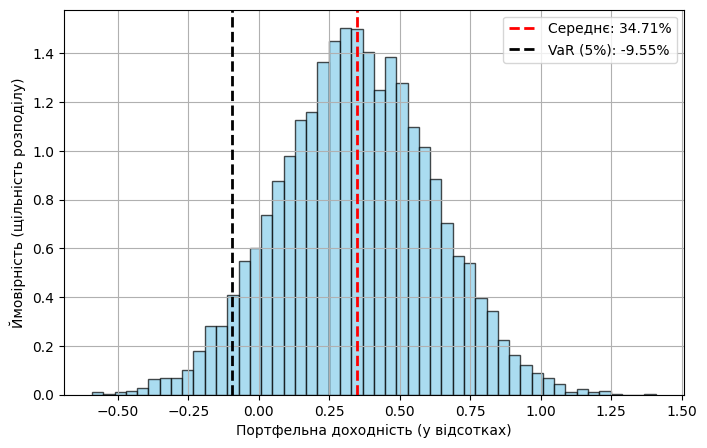

In [ ]:
# Завантажуємо історичні дані для активів
assets: list[str] = ["TSLA", "GOOG", "GM"]
# Візьмемо часовий період 5 років
start_date: str = (datetime.today() - timedelta(days=5 * 365)).strftime('%Y-%m-%d')
end_date: str = datetime.today().strftime('%Y-%m-%d')

# Функція для отримання історичних даних
def get_stock_data(tickers: list[str], start: str, end: str) -> pd.DataFrame:
    df = yf.download(tickers, start=start, end=end)

    print("Отримані стовпці:", df.columns)
    if "Adj Close" in df:
        df = df["Adj Close"]
    elif "Close" in df:
        df = df["Close"]
    else:
        raise KeyError("Немає стовпців 'Adj Close' або 'Close' у завантажених даних!")

    return df.pct_change().dropna()  # Обчислюємо щоденну доходність

returns_data: pd.DataFrame = get_stock_data(assets, start_date, end_date)

# Розрахунок річних статистик
mu: np.ndarray = returns_data.mean() * 252              # Річна середня доходність
sigma: np.ndarray = returns_data.std() * np.sqrt(252)   # Річна волатильність

# Ваги активів у портфелі
w: np.ndarray = np.array([0.4, 0.3, 0.3])

# Кількість симуляцій
n_sim: int = 10_000

# Симуляція доходностей активів методом Монте-Карло
simulated_returns: np.ndarray = np.random.normal(loc=mu, scale=sigma, size=(n_sim, len(assets)))

# Розрахунок доходності портфеля
portfolio_returns: np.ndarray = simulated_returns.dot(w)

# Очікувана доходність портфеля та ризик (стандартне відхилення)
expected_return: float = float(np.mean(portfolio_returns))
std_return: float = float(np.std(portfolio_returns))

# Value-at-Risk (VaR) на рівні 5%
VaR_5: float = float(np.percentile(portfolio_returns, 5))

print(f"Очікувана доходність портфеля: {expected_return:.2%}")
print(f"Ризик портфеля (стандартне відхилення): {std_return:.2%}")
print(f"Value-at-Risk (5%): {VaR_5:.2%}")

plt.figure(figsize=(8, 5))
plt.hist(portfolio_returns, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(expected_return, color='red', linestyle='--', linewidth=2, label=f'Середнє: {expected_return:.2%}')
plt.axvline(VaR_5, color='black', linestyle='--', linewidth=2, label=f'VaR (5%): {VaR_5:.2%}')
plt.xlabel("Портфельна доходність (у відсотках)")
plt.ylabel("Ймовірність (щільність розподілу)")
plt.legend()
plt.grid(True)
plt.show()

Аналіз статистичних показників
Очікувана доходність портфеля складає $34.71\%$. Тобто активи мають значний потенціал зростання в майбутньому. \
Стандартне відхилення $\approx 27\%$, свідчить про те, що присутні суттєві коливання доходності портфеля. Це означає, що інвестор може стикатися з різкими змінами вартості активів. \
VaR на рівні $5\% -9.55\%$ визначає, що в $5\%$ найгірших сценаріїв втрати портфеля за рік можуть досягати $9.55\%$ або більше.

Рекомендації щодо ребалансування портфеля:
1. Зменшення стандартного відхилення. \
    Збільшити частку менш волатильних активів (наприклад, додати облігації). \
    Додати "захисні" активи (наприклад, золото або нерухомість).

2. Оптимізація співвідношення доходності та ризику. \
    Розглянути диверсифікацію в інші сектори.

3. Перегляд ваг у портфелі. \
    Поточні ваги: TSLA – $30\%$, GOOG – $30\%$, GM – $40\%$.
    Якщо зменшити частку GM і TSLA на користь GOOG, то ризик може трохи знизитися, оскільки GOOG менш волатильний.
    Альтернативний варіант: зменшити частку всіх трьох активів і додати один або два стабільних активів (наприклад, S&P 500 ETF або короткострокові облігації).

Висновок:
- Поточний портфель має високу очікувану доходність, але також значний ризик.
- VaR ($5\%$) $-9.55\%$ означає, що потенційні втрати можуть бути суттєвими.

Додаткове завдання (на +1 бал)
1. Обмеження методу Монте-Карло для оцінки портфельної доходності \
Метод Монте-Карло широко використовується для оцінки ризиків та доходності, але він має певні обмеження:
- Більшість симуляцій базується на нормальному розподілі доходностей активів, але реальні ринки часто мають leptokurtic distribution, що означає більш часті екстремальні рухи цін.
- Метод не враховує можливі залежності між доходностями у часі (наприклад, ефект тренду чи реверсії до середнього).
- Для великих портфелів із багатьма активами метод Монте-Карло може вимагати значних обчислювальних ресурсів.

2. Альтернативні методи аналізу та управління портфелем
- Модель Марковіца (Mean-Variance Optimization, MVO)
- Модель Black-Litterman
- Bootstrapping (Перестановочний аналіз)
- Методи машинного навчання
- Квантільне моделювання (Quantile Regression)

3. Чи можна використовувати інші розподіли ймовірностей для моделювання доходностей активів?
Можна використовувати альтернативні розподіли:
- T-розподіл (Student’s t-distribution)
- Експоненційний або Пуассонівський розподіл


Аргументи "за" і "проти" альтернативних розподілів.
- Плюси:
    - Краще враховують кризові сценарії.
    - Дають більш точні оцінки ризику, особливо для портфелів з активами високої волатильності.
- Мінуси:
    - Ускладнюють розрахунки.
    - Потребують більше даних для точної калібровки параметрів.
    - Можуть бути менш інтуїтивно зрозумілими для інвесторів.

4. Як врахувати невизначеність щодо майбутніх доходностей активів?
- Байєсівський підхід \
    Використання апостеріорних розподілів для оновлення прогнозів у реальному часі.
- Чутливісний аналіз \
    Оцінка впливу екстремальних подій (кризи, рецесії) на портфель.
- Моделювання випадкових процесів (Geometric Brownian Motion, GARCH) \
    Використання фінансових моделей для прогнозування майбутньої волатильності та доходності.

5. Альтернативні методи оцінки ризику (крім VaR)
- Conditional Value-at-Risk (CVaR, Expected Shortfall) \
    Оцінює середній збиток у найгірших 5% випадків, забезпечуючи більш точну оцінку ризику в екстремальних ситуаціях.
- Drawdown \
    Аналізує найбільше падіння портфеля від пікової вартості.
- Sharpe Ratio / Sortino Ratio \
    Sharpe Ratio: враховує співвідношення доходності до загальної волатильності. \
    Sortino Ratio: подібний до Sharpe, але враховує лише негативну волатильність.
- Коваріаційний аналіз
    Дозволяє оцінити, як різні активи в портфелі впливають один на одного, і мінімізувати корельовані ризики.